# LAMA into the Wild Part1: DataPreperation

# Overview

In this section We will preprocess the Data that we needed in the whole program. The result will be stored in `../data/pre`

In [29]:
import os
import gc

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

from data import DATA_DIR
from lama.util.StreamerBuilder import StreamerBuilder, to_tuple
from lama.preprocessing.DataProcessor import nans, change_object_cols, reformat_dataframe

# 1.1 Define Global Constants

To make our reading and writing more easier, we decide to define some global constants below, you can change them if you'd like to write to another location.

In [30]:
OUT_DIR = os.path.join(DATA_DIR, "pre")

The process looks alike, we will handle them one by one.

- filter out Nan values
- check unique columns
- convert object values to numericals
- catagorize discrete and continous features
- scaling columns with Standardizer or Normalizer. 

# Train and Test

We will first handle train and test dataset.

In [31]:
df_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), header=0)
df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), header=0)

* check nans

In [32]:
# check nans
print(f'df_test nans: \n{nans(df_test)}\n')
print(f'df_train nans: \n{nans(df_train)}\n')

df_test nans: 
first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

df_train nans: 
first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64



We can see that in `df_test` there is one nan row, although it is trival compared to the total value, we choose to drop it. 

In [33]:
df_test_copy = df_test.dropna()

Before we go on to next section. lets check if there is abnormal distribution in train dataset.

unexpected value: 2207


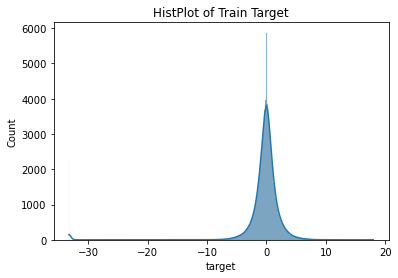

In [34]:
sns.histplot(df_train['target'], kde=True).set(title="HistPlot of Train Target")
unexpected = (df_train['target'] < -30).sum()
print(f'unexpected value: {unexpected}')

Clearly there exists some unexpected values when target < -30.


One more thing to notice is the distributiton is symmetric to 0. 

[Text(0.5, 1.0, 'HistPlot of Train Target')]

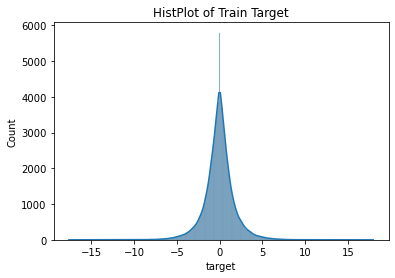

In [35]:
df_train_copy = df_train[df_train['target'] > -30]
sns.histplot(df_train_copy['target'], kde=True).set(title="HistPlot of Train Target")

then we check if the id is unique, this procedure is important as we might need to outer join other datasets with id. 

In [36]:
train_count = df_train_copy.shape[0]
test_count = df_test_copy.shape[0]
print(df_train_copy['card_id'].nunique() == train_count)
print(df_test_copy['card_id'].nunique() == test_count)

True
True


In [37]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199710 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  199710 non-null  object 
 1   card_id             199710 non-null  object 
 2   feature_1           199710 non-null  int64  
 3   feature_2           199710 non-null  int64  
 4   feature_3           199710 non-null  int64  
 5   target              199710 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 10.7+ MB


Now we have to convert obejct to numeric values, as we seen above, there are two object values, since the card_id is a foreign key bound to match more features in other dataset, we'll leave it intact. 

In [38]:
features = ['first_active_month']
df_test_copy, df_train_copy = \
    StreamerBuilder.build([df_test_copy, df_train_copy]) \
                .map(lambda df: reformat_dataframe(df, features, change_object_cols)) \
                .collect(to_tuple)

After change the columns we would like to see if the train and test features are evenly splitted.

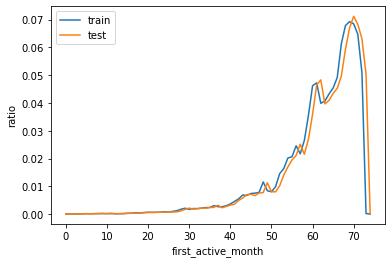

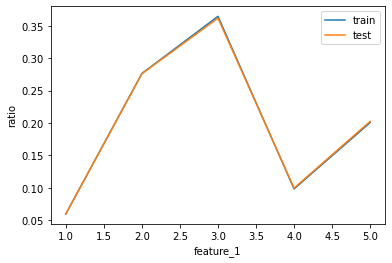

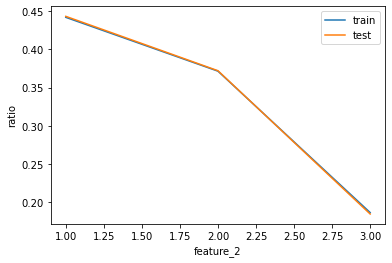

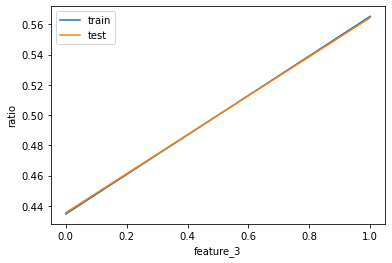

In [39]:
features = ['first_active_month', 'feature_1', 'feature_2', 'feature_3']
for feature in features:
    (df_train_copy[feature].value_counts().sort_index() / train_count).plot()
    (df_test_copy[feature].value_counts().sort_index() / test_count).plot()
    plt.legend(['train', 'test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()

Now we need to standarize the features

In [40]:
mapper = lambda df: preprocessing.StandardScaler().fit_transform(df.values.reshape(-1, 1))
features = ['first_active_month', 'feature_1', 'feature_2', 'feature_3']
df_test_copy, df_train_copy = \
    StreamerBuilder.build([df_test_copy, df_train_copy]) \
    .map(lambda df: reformat_dataframe(df, features, mapper)) \
    .collect(to_tuple)
del mapper

Last step is to write the result back, and fetch when we needed.

In [41]:
df_test_copy.to_csv(os.path.join(OUT_DIR, 'test_pre.csv'), index=False)
df_train_copy.to_csv(os.path.join(OUT_DIR, 'train_pre.csv'), index=False)

del df_test, df_test_copy, df_train, df_train_copy, features, test_count, train_count, unexpected
gc.collect()

14167